In [88]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad
from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats

import scipy as sp
from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi, factorial, gamma

# from tb_utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dz, x2z, x2z_dx, evaluate_jacobi_grid, constructMinv, jacobi_p_normalisation_const
from tb_utils import *
import itertools
from scipy.sparse import diags, kron, eye, spdiags

import warnings
warnings.filterwarnings('ignore')

# Toy problem

In [ ]:
# eps = 0.001
eps = 0.1
x0, xN = 0, 1
g0, gN = 0, 0
# a_pde, b_pde, c_pde = -eps, -1, 0

def f(x): return np.ones(x.shape[0])

def u_exact_solution(x, eps=eps): return (np.exp(-x/eps) + (x - 1) - np.exp(-1/eps)*x)/(np.exp(-1/eps) - 1)

## Nodal Continous Galerkin - one domain

In [80]:
alpha, beta = 0, 0 # Legendere polynomials
N = 10
J = (xN - x0) / 2

z = JacobiGL(alpha=alpha, beta=beta, N=N) # z are the points in [-1,1]
D_z = constructD(z=z, alpha=alpha, beta=beta, a=-1, b=1)

M_inv = constructMinv(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M = np.linalg.inv(M_inv)

L_N = (eps/J**2) * (D_z.T @ M @ D_z) - (1/J) * (M @ D_z)
L_N[0, :] = 0; L_N[0, 0] = 1
L_N[N, :] = 0; L_N[N, N] = 1
print(f"{np.linalg.cond(L_N)}")

w = 2 / (N * (N+1)) / np.power(eval_jacobi(N, alpha, beta, z), 2)
fx = w.copy()
fx[0] = g0; fx[N] = gN

u_z = linalg.solve(L_N, fx) # in nodal space

x = z2x(z=z, a=x0, b=xN)
u_x = u_z

63.117842835674146


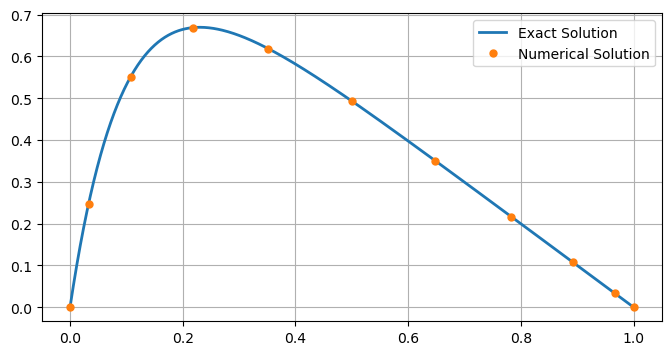

In [82]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax.plot(x, u_x, 'o', label="Numerical Solution", markersize=5)
# ax[0].plot(x_eval, u_eval, linestyle='--', label="Interpolated Solution", linewidth=2)
ax.grid();
ax.legend();

## SEM - Nodal Continous Galerkin - multiple domain

In [201]:
x_split = 0.1
alpha, beta = 0, 0 # Legendere polynomials
N = 10
J_1 = (x_split - x0) / 2
J_2 = (xN - x_split) / 2
print(f"{J_1 = }; {J_2 = }")

z = JacobiGL(alpha=alpha, beta=beta, N=N) # z are the points in [-1,1]
D_z = constructD(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M_z_inv = constructMinv(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M_z = np.linalg.inv(M_z_inv)

L_N_1 = (eps/J_1) * (D_z.T @ M_z @ D_z) - (M_z @ D_z)
L_N_1[0, :] = 0; L_N_1[0, 0] = 1
# L_N_1[N, :] = 0; L_N_1[N, N] = 1

L_N_2 = (eps/J_2) * (D_z.T @ M_z @ D_z) - (M_z @ D_z)
# L_N_2[0, :] = 0; L_N_2[0, 0] = 1
L_N_2[N, :] = 0; L_N_2[N, N] = 1

print(f"{np.linalg.cond(L_N_1) = }; {np.linalg.cond(L_N_2) = }")
# L_N = sp.linalg.block_diag(L_N_1, L_N_2)

w = 2 / (N * (N+1)) / np.power(eval_jacobi(N, alpha, beta, z), 2)
f_1 = J_1 * w.copy(); f_2 = J_2 * w.copy()
f_1[0] = g0;
f_2[N] = gN

L_N = np.zeros((2*(N+1)-1, 2*(N+1)-1))
f = np.zeros(2*(N+1)-1)

L_N[0:N+1, 0:N+1] += L_N_1
L_N[N:, N:] += L_N_2

f[0:N+1] += f_1
f[N:] += f_2

u_z = np.linalg.solve(L_N, f) # in nodal space

x_elem1 = z2x(z, x0, x_split)
x_elem2 = z2x(z, x_split, xN)
x_global = np.concatenate([x_elem1[:-1], x_elem2])

# x = z2x(z=z, a=x0, b=xN)
# u_x = u_z

J_1 = 0.05; J_2 = 0.45
np.linalg.cond(L_N_1) = np.float64(835.4060915836205); np.linalg.cond(L_N_2) = np.float64(75.17720809028569)


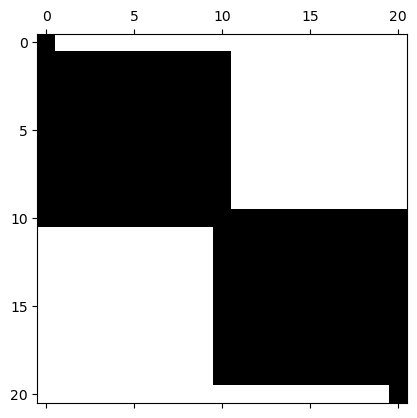

In [202]:
plt.spy(L_N)

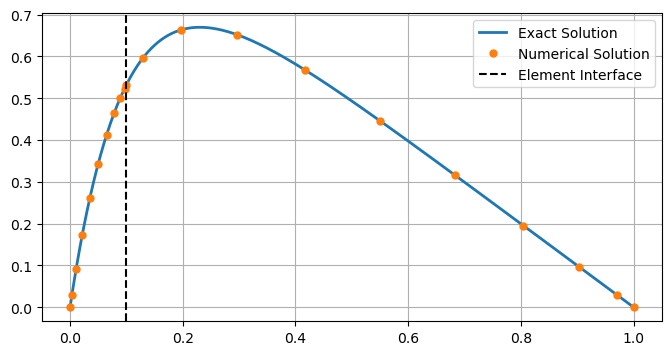

In [203]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax.plot(x_global, u_z, 'o', label="Numerical Solution", markersize=5)
ax.axvline(x_split, color='k', linestyle='--', label='Element Interface')
ax.grid();
ax.legend();